In [1]:
%pip install ipykernel kafka-python pandas matplotlib folium python-dateutil ipython

Note: you may need to restart the kernel to use updated packages.


In [2]:
import json
import logging
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil import parser
from kafka import KafkaConsumer
from IPython.display import clear_output, display, IFrame
import folium
from folium.plugins import MarkerCluster

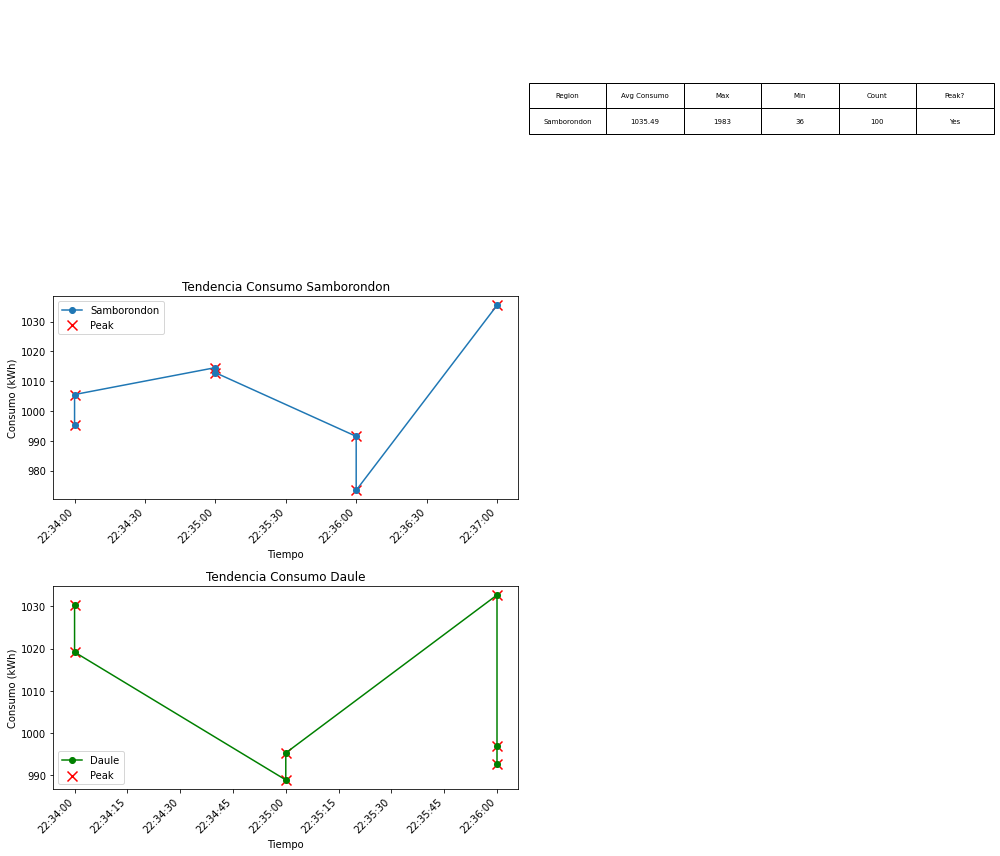

In [ ]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Load medidores data if available
medidores_df = pd.DataFrame(columns=['id', 'region', 'lat', 'long'])
medidores_path = '/app/medidores.json'
if os.path.exists(medidores_path):
    try:
        with open(medidores_path, 'r') as f:
            medidores = json.load(f)
        medidores_df = pd.DataFrame(medidores)
        logger.info(f"Loaded {len(medidores_df)} medidores from {medidores_path}.")
    except Exception as e:
        logger.error(f"Error loading medidores.json: {e}")
else:
    logger.warning(f"{medidores_path} not found. Using empty medidores_df.")

# Kafka Consumer Configuration
consumer = KafkaConsumer(
    'output',
    bootstrap_servers='kafka:9092',
    auto_offset_reset='latest',
    group_id='visualization-group',
    value_deserializer=lambda m: json.loads(m.decode('utf-8')),
)

data_records = []
MAX_RECORDS = 100

def get_color_by_consumption(consumo):
    """Assign color based on average consumption."""
    if consumo is None:
        return 'blue'
    if consumo < 500:
        return 'green'
    elif consumo < 1000:
        return 'orange'
    else:
        return 'red'

def update_dashboard(df):
    # Clear the notebook output cell
    clear_output(wait=True)

    # Ensure window_start is datetime
    df['window_start'] = pd.to_datetime(df['window_start'], errors='coerce')
    df = df.dropna(subset=['window_start'])
    if df.empty:
        logger.warning("No valid data to visualize.")
        return

    # Get latest window and filter data for that window
    latest_window = df['window_start'].max()
    latest_data_window = df[df['window_start'] == latest_window]

    # Create Folium map if medidores_df is available
    map_html = None
    if not medidores_df.empty:
        avg_lat = medidores_df['lat'].mean()
        avg_long = medidores_df['long'].mean()
        m = folium.Map(location=[avg_lat, avg_long], zoom_start=12)
        marker_cluster = MarkerCluster().add_to(m)

        region_avg = latest_data_window.set_index('region')['avg_consumo'].to_dict()

        for _, medidor in medidores_df.iterrows():
            region = medidor['region']
            avg_consumo_region = region_avg.get(region)
            color = get_color_by_consumption(avg_consumo_region)
            popup_text = f"Region: {region}<br>"
            if avg_consumo_region is not None:
                popup_text += f"Avg. Consumo: {avg_consumo_region:.2f} kWh"
            else:
                popup_text += "Avg. Consumo: N/A"
            folium.CircleMarker(
                location=[medidor['lat'], medidor['long']],
                radius=8,
                color=color,
                fill=True,
                fill_color=color,
                popup=popup_text
            ).add_to(marker_cluster)

        map_html = 'map.html'
        m.save(map_html)

    # Split historical data by region
    historical_samborondon = df[df['region'] == 'Samborondon'].sort_values('window_start')
    historical_daule = df[df['region'] == 'Daule'].sort_values('window_start')

    # Create a new figure for each update
    fig, axes = plt.subplots(3, 2, figsize=(14, 12))

    # (0,0) for map placeholder
    ax_map = axes[0,0]
    ax_map.axis('off')
    if map_html:
        # Display map below this cell
        display(IFrame(map_html, width='500', height='400'))
    #else:
    #    if medidores_df.empty:
    #        ax_map.text(0.5, 0.5, 'No medidores data', ha='center', va='center', fontsize=14)
    #    else:
    #        ax_map.text(0.5, 0.5, 'Mapa no disponible', ha='center', va='center', fontsize=14)

    # (0,1) Indicators table
    ax_table = axes[0,1]
    ax_table.axis('off')
    table_data = [['Region', 'Avg Consumo', 'Max', 'Min', 'Count', 'Peak?']]
    for _, row in latest_data_window.iterrows():
        peak_str = 'Yes' if row['is_peak'] else 'No'
        table_data.append([
            row['region'],
            f"{row['avg_consumo']:.2f}",
            row['max_consumo'],
            row['min_consumo'],
            row['count_consumo'],
            peak_str
        ])
    tbl = ax_table.table(cellText=table_data, loc='center', cellLoc='center')
    tbl.set_fontsize(12)
    tbl.scale(1, 2)

    # (1,0) Samborondon Trend
    ax_sam = axes[1,0]
    ax_sam.clear()
    if not historical_samborondon.empty:
        ax_sam.plot(historical_samborondon['window_start'], historical_samborondon['avg_consumo'], marker='o', label='Samborondon')
        # Mark peaks (>1200 indicated by is_peak == True)
        sam_peaks = historical_samborondon[historical_samborondon['is_peak']]
        if not sam_peaks.empty:
            ax_sam.scatter(sam_peaks['window_start'], sam_peaks['avg_consumo'], color='red', marker='x', s=100, label='Peak')
        ax_sam.set_title('Tendencia Consumo Samborondon')
        ax_sam.set_xlabel('Tiempo')
        ax_sam.set_ylabel('Consumo (kWh)')
        ax_sam.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        plt.setp(ax_sam.get_xticklabels(), rotation=45, ha='right')
        ax_sam.legend()
    else:
        ax_sam.text(0.5, 0.5, 'No Data Samborondon', ha='center', va='center')

    # (2,0) Daule Trend
    ax_dau = axes[2,0]
    ax_dau.clear()
    if not historical_daule.empty:
        ax_dau.plot(historical_daule['window_start'], historical_daule['avg_consumo'], marker='o', color='green', label='Daule')
        dau_peaks = historical_daule[historical_daule['is_peak']]
        if not dau_peaks.empty:
            ax_dau.scatter(dau_peaks['window_start'], dau_peaks['avg_consumo'], color='red', marker='x', s=100, label='Peak')
        ax_dau.set_title('Tendencia Consumo Daule')
        ax_dau.set_xlabel('Tiempo')
        ax_dau.set_ylabel('Consumo (kWh)')
        ax_dau.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        plt.setp(ax_dau.get_xticklabels(), rotation=45, ha='right')
        ax_dau.legend()
    else:
        ax_dau.text(0.5, 0.5, 'No Data Daule', ha='center', va='center')

    # (1,1) and (2,1) are unused axes, we can just hide them
    axes[1,1].axis('off')
    axes[2,1].axis('off')

    plt.tight_layout()
    display(fig)
    plt.close(fig)

# Real-time data consumption loop
try:
    logger.info("Starting data consumption loop...")
    while True:
        message_pack = consumer.poll(timeout_ms=1000, max_records=10)
        if not message_pack:
            continue
        for tp, messages in message_pack.items():
            for message in messages:
                data = message.value
                logger.info(f"Received data: {data}")

                required_fields = ['window_start', 'window_end', 'region', 'avg_consumo', 'max_consumo', 'min_consumo', 'count_consumo', 'is_peak']
                if not all(field in data for field in required_fields):
                    logger.error(f"Incomplete data received: {data}")
                    continue

                data_records.append({
                    'window_start': data['window_start'],
                    'window_end': data['window_end'],
                    'region': data['region'],
                    'avg_consumo': data['avg_consumo'],
                    'max_consumo': data['max_consumo'],
                    'min_consumo': data['min_consumo'],
                    'count_consumo': data['count_consumo'],
                    'is_peak': data['is_peak']
                })

                # Keep only the last MAX_RECORDS records
                if len(data_records) > MAX_RECORDS:
                    removed_record = data_records.pop(0)
                    logger.debug(f"Removed oldest record: {removed_record}")

                df = pd.DataFrame(data_records)
                # Update the dashboard with the latest data (no extra argument)
                update_dashboard(df)

except KeyboardInterrupt:
    logger.info("Visualization stopped by user.")
finally:
    consumer.close()
    logger.info("Kafka consumer closed.")
